# **A Better Trade: Predicting Short Term Bitcoin Returns**

Forest Hensley, Jesse Marder, AJ Martinez, Brandyn Waterman

Codeup Capstone Project, Innis cohort

June 16, 2022


# Introduction

Cryptocurrencies have become much more widely adopted since 2017, with the most recent announcement by Fidelity that Bitcoin will be offered for 401ks demonstrating its potential use for mainstream investment. Still, the speculative and volatile nature of the currencies as well as extensive industry promotion efforts have resulted in many small-scale retail traders entering the market, potentially with little to no experience in the field. 

# Goal

This project examines factors affecting short term (1 day) returns in an effort to provide traders viable strategies for profiting from Bitcoin, with possible future application for other assets. 

# Data to Consider

- General value information:  values of daily open, high, low, and close prices
- Supply information: miner revenue features, Hash rate, difficulty, S2F (stock-to-flow)
- Demand information: volume, price momentum and volatility (MACD), time analysis (day of week/month)
- Sentiment information: twitter sentiment analysis 

# The plan

## *Imports*

Pulls imports from `/utils/imports.py`

In [1]:
# import all from imports.py
from imports import *

# # *** no more warnings ***
import warnings
warnings.filterwarnings("ignore")

# Wrangling, Exploration, and Modeling Modules
from tidy import *
from wrangle import *
from model import *
from explore import *

SyntaxError: invalid syntax (explore.py, line 16)

## *1. Data Acquisition*

Data for this project was acquired from the following sources:
- Price data was acquired using Yahoo Finance and consists of data from 2014 - 2022. The csv was downloaded from the website.
- Tweets with #bitcoin and/or #btc (the ticker symbol for Bitcoin) were acquired from three different sources. 
- Early tweets from before 2019 were from a csv downloaded from Kaggle
- Tweets from 2019 - May 2022 were scraped using the snscrape library
- Data about miner features and total-bitcoins were acquired from Blockchain.com



## *2. Data Preparation*

  We conducted an initial exploration of the data by examining relationships between each of the features and treated 1 day forward log returns as the target. Next, I explored further using premier tools such as Pandas, Python, Statsmodels, etc..., to answer the initial questions posed above. Data exploration continues by delving into the descriptive statistics of the dataset. Further investigation includes up / down -sampling, frequency analysis, lag response, and autocorrelation. I found the frequency analysis revealed potential price indicators.

Data preparation consisted of the following:
- Price data was investigated 
- Tweet data was cleaned by removing nulls, converting column formats, and removed non-letter and non-digit characters.


## *3. Exploration*


QUESTIONS:

1. Does high volatility result in above average returns?



In [ ]:
# Get DataFrame of price data with targets and features
df = wrangle_df()

## Target analysis:

### We analyzed two different targets:
- forward logarithmic returns (log of tomorrow's close - log of today's close)
- whether tomorrow's close is higher than today's (fwd_close_positive)

Examining logarithmic returns is a common practice when analyzing financial time series data and is useful for the following reasons:
- Normalizes the data which helps with comparing two assets with very different values, such as Bitcoin (~\\$30000) and Ethereum ($1800)
- Easier to assume normality of results so better application of classical statistical methods

We also looked at whether tomorrow's close is higher or lower than today, which allows for a simple binary classification exercise and may be good enough for implement for a trading strategy.

In [ ]:
perform_target_return_analysis(df)

Average log returns are just above 0.

In [ ]:
perform_target_return_analysis(df, target = 'fwd_close_positive')

A small bias for next day's close being positive. This makes sense based on the overall upward trend in close price in the dataset.

### Does higher volatility result in above average returns?

With a reputation for extreme volatility Bitcoin has the potential to be a valuable market for exploiting strong price movements in a short time. Large movements in price draw media coverage and consequently additional public awareness and trader participation. Rewards may be high, but so is risk. To this end we asked how does above average volatility affect short term returns?

To quantify volatility we the examined current day’s Average True Range (ATR) vs historical (14 day) ATR. ATR represents the range of prices observed between high and low, high and close, and low and close. Wider ranges imply greater volatility. Shown below is the average next day return for when the current day’s ATR is above historical ATR by the given threshold.

- Measure this using ATR:
    - TR = Max[(H-L), Abs(H-Cp), Abs(L-Cp)]
    - ATR = (1/n)* sum(TRi)

In [ ]:
plot_consolidated_atr_analysis(df)

In [10]:
# thresholds_to_try = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
# returns = {}
# for threshold in thresholds_to_try:
#     avg_return = tidy.perform_ATR_analysis(df, atr_threshold=threshold, make_plots=False)
#     returns[threshold] = avg_return

In [11]:
# pd.DataFrame(returns, index = ['avg_return']).T.plot.bar(legend=False)
# plt.title('Average Next Day Return when ATR is \nAbove 14 Day Average ATR by Threshold Amount')
# plt.xlabel('Threshold')
# plt.ylabel('Average Return')
# plt.axhline(df.fwd_log_ret.mean(), color = 'r')
# plt.annotate('Overall Mean', (5, 0.0017))

Average next day returns are positive when current volatility measured by ATR is higher than historical volatility and in fact reach a peak when ATR is 20% greater than average. Above 20% average returns decline and actually turn negative when volatility is very high. This analysis indicates that it could be a good time to buy for the short term when market volatility picks up but make sure you’re out of the market (or initiate a short position) if it gets very choppy. 

### Time Exploration

QUESTIONS: 

- Is there an importance to what month of the year?
- Is there an importance to what day of the week?
- Is there an importance for what day of the month?

In [9]:
# Set our target variable as y
y = df.fwd_log_ret

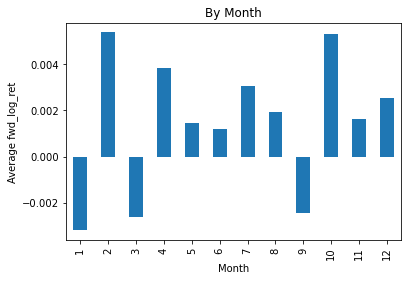

In [10]:
# Check for importance by month of year
by_month = y.groupby(y.index.month).mean().plot.bar()
plt.title('By Month')
plt.xlabel('Month')
plt.ylabel('Average fwd_log_ret')
plt.show()

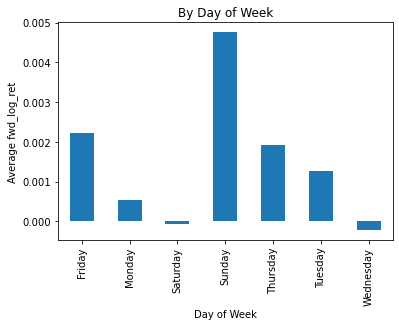

In [11]:
# Check for importance by day of the week
by_day_of_week = y.groupby(y.index.day_name()).mean().plot.bar()
plt.title('By Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average fwd_log_ret')
plt.show()

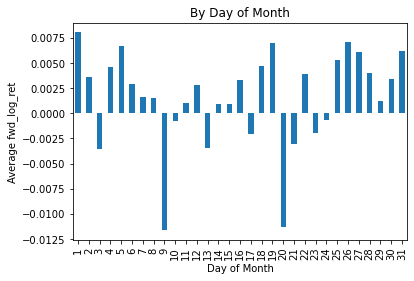

In [12]:
# Check for importance of day of the month
by_day_of_month = y.groupby(y.index.day).mean().plot.bar()
plt.title('By Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Average fwd_log_ret')
plt.show()

We can see that there does seem to be a possibility of singificance based on these categorizations. The next step is to test if this can be useful to us, for use as engineered features, based on statistical significance. In the notebooks you can see the individual testing, and in the tidy.py module the time_features() function will perform a 1 sample t-test on both tails and add these encoded columns to the dataframe. For this data this produces two months and three days that are deemed significant. (Month 9 and 10, Days 1, 9, and 20)

In [15]:
# Additional exploration (MACD/Miner info)

## *4. Modeling So Far*

In [16]:
# For ease of use acquiring our df from our wrangle.py module
df = wrangle_df()

cached csv


### *For the Regression modeling the target variable will be the fwd_log_ret column and for the Classification modeling the target variable will be the fwd_close_positive column.*

### Splitting:

Prior to modeling there a few splitting techniques that are being utilized. 

- Manual time split
    - Two split method where a train, validate set is used for initial modeling (with a month for test never touched)
    - Second split method where the previous validate is absorbed into train and test is brought forward 

In [17]:
# Manual splitting
def split_i(df):
    train = df.loc[:'2022-3-22']
    validate =df.loc['2022-03-23':'2022-04-23'] 
    return train, validate

def split_ii(df):
    train = df.loc[:'2022-04-24']
    test = df.loc['2022-04-25':]
    return train, test

# We can see the min and max dates for our df
df.index.min(), df.index.max()

(Timestamp('2014-10-20 00:00:00'), Timestamp('2022-05-24 00:00:00'))

In [18]:
# We can drop fwd_ret and fwd_pct_chg entirely
df = df.drop(columns=['fwd_ret', 'fwd_pct_chg'])

# Splitting our data for use with modeling 
train_i, validate_i = split_i(df)
train_ii, test_ii = split_ii(df)

In [19]:
df.head()

,open,high,low,close,volume,fwd_log_ret,fwd_close_positive,cross,histy,month_9,...,atr_above_threshold_0.1,atr_above_threshold_0.2,atr_above_threshold_0.3,avg-fees-per-transaction,cost-per-transaction-percent,cost-per-transaction,difficulty,hash-rate,miners-revenue,transaction-fees-to-miners
2014-10-20,389.230988,390.084015,378.252014,382.845001,16419000,0.009437,1,0.0,1.0,0,...,False,False,False,0.059651,2.830044,24.826121,3.500248e+10,233157.697776,1.747486e+06,4198.799233
2014-10-21,382.420990,392.645996,380.834015,386.475006,14188900,-0.008620,0,0.0,1.0,0,...,False,False,False,0.060749,2.830044,20.194035,3.500248e+10,233157.697776,1.903490e+06,5726.216590
2014-10-22,386.118011,388.575989,382.248993,383.157990,11641300,-0.066750,0,0.0,1.0,0,...,False,False,False,0.060749,2.830044,20.194035,3.500248e+10,297537.062088,1.903490e+06,5726.216590
2014-10-23,382.962006,385.048004,356.446991,358.416992,26456900,-0.000201,0,0.0,1.0,0,...,False,False,False,0.060749,2.566983,20.194035,3.500248e+10,297537.062088,1.903490e+06,5726.216590
2014-10-24,358.591003,364.345001,353.304993,358.345001,15585700,-0.031391,0,0.0,1.0,0,...,False,False,False,0.056403,2.566983,18.762679,3.500248e+10,297537.062088,1.603290e+06,4819.681933


In [20]:
# Scaling the continuous variables
quants = [
        'open', 'high', 'low', 'close', 'volume', 'avg-fees-per-transaction', 'cost-per-transaction-percent', 
        'cost-per-transaction', 'difficulty', 'hash-rate', 'miners-revenue', 'transaction-fees-to-miners'
         ]
scaler = MinMaxScaler()
scaler.fit(train_i[quants])

train_i[quants] = scaler.transform(train_i[quants])
validate_i[quants] = scaler.transform(validate_i[quants])

scaler2 = MinMaxScaler()
scaler2.fit(train_ii[quants])

train_ii[quants] = scaler2.transform(train_ii[quants])
test_ii[quants] = scaler2.transform(test_ii[quants])

In [21]:
# X and Y Splits for regression models:

# Dropping our target and all fwd columns (to avoid 'looking' into the future)
x_train_i = train_i.drop(columns=['fwd_log_ret', 'fwd_close_positive'])
x_train_ii = train_ii.drop(columns=['fwd_log_ret', 'fwd_close_positive'])

y_train_i = train_i['fwd_log_ret']
y_train_ii = train_ii['fwd_log_ret']

x_validate_i = validate_i.drop(columns=['fwd_log_ret', 'fwd_close_positive'])
x_test_ii = test_ii.drop(columns=['fwd_log_ret', 'fwd_close_positive'])

y_validate_i = validate_i['fwd_log_ret']
y_test_ii = test_ii['fwd_log_ret']

In [22]:
# Making our target series into a dataframe for ease of use
y_train_i = pd.DataFrame(y_train_i)
y_train_ii = pd.DataFrame(y_train_ii)

y_validate_i = pd.DataFrame(y_validate_i)
y_test_ii = pd.DataFrame(y_test_ii)

### *Regression Modeling*

For regression our metric for evaluation is RMSE. The notebooks contain a number of different methods and here we will just post some of the leading results so far.

In [23]:
# Establishing a baseline RMSE for our initial modeling train split
baseline_RMSE_i = baseline_selection(y_train_i, 'fwd_log_ret')

Mean provides a better baseline. Returning mean RMSE of 0.039188695988946885.


In [24]:
# Establishing a baseline RMSE for our final test modeling to be compared to
baseline_RMSE_ii = baseline_selection(y_train_ii, 'fwd_log_ret')

Mean provides a better baseline. Returning mean RMSE of 0.039041302984912506.


The best performing Regression model was an OLS model. Using the ols_model() function we can return our RMSE values for train and validate (or train and test). 

In [25]:
# Obtaining train and validate RMSE values 
rmse_train, rmse_validate = ols_model(x_train_i, y_train_i, x_validate_i, y_validate_i, 'fwd_log_ret')
print("RMSE for OLS using LinearRegression\nTraining: ", rmse_train,
            "\nValidation: ", rmse_validate)

RMSE for OLS using LinearRegression
Training:  0.038786 
Validation:  0.023159


In [26]:
# Obtaining train and test RMSE values representing the second split
rmse_train2, rmse_test = ols_model(x_train_ii, y_train_ii, x_test_ii, y_test_ii, 'fwd_log_ret')
print("RMSE for OLS using LinearRegression\nTraining: ", rmse_train2,
            "\nTest: ", rmse_test)

RMSE for OLS using LinearRegression
Training:  0.038639 
Test:  0.042275


As seen the both training and the validate dataframes do beat the baseline, but the test dataframe does not. 

### *Classification Modeling*

For classification our metric for evaluation is accuracy. The notebooks contain a number of different methods and here we will just post some of the leading results so far.

# Conclusion

As of right now none of the models perform well enough to recommend their use for real world trading. While some of the train and validate sets perform slightly better than the baselines, when applied to the test set the performance is equal (to baseline) at best. When one considers the real world use of trading fees it becomes clear that the models in their current state could not be used with beneficial results.  

# Next Steps

We are still modifying and tailoring the engineered features to hopefully produce a result that can be competitive for the purposes of a profit for day to day trading. There are a number of features that were not included in the dataframe for this first iteration that will be included moving forward and some of the features that were included in this dataset can be more refined and accurate in our next iteration. 

There is a consideration right now of modifying the timeframe we are working with, currently it is the entire available history, to only the most recent three years. This may prove to be more reliable given the type of question we are seeking to answer and the volatility and relational tendency Bitcoin seems to have. The outcome of the price, or direction of it, seems to have more to do with the datapoints around it than with incredibly old historical data and that is the direction we will now be moving in. 

---
# Appendix

## *Data Dictionary*

Variables | Definition
--- | ---
 time | time candlestick opened
Open | price at open of the day
High | highest price during the day
Low | lowest price during the day
Close | price at close of the day
Volume | number of $ USD traded during interval
volume | Amount in $ USD traded for the day
fwd_log_ret | the log of tomorrow's close - the log of today's lose
fwd_close_positive | whether tomorrow's close is higher than today's
cross |
histy | 
month_9 | Encoded column for transaction during month 9 (September)
month_10 | Encoded column for transaction during month 10 (October)
day_20 | Encoded column for transaction on month day 20
day_1 | Encoded column for transaction on first day of month
day_9 | Encoded column for transaction on month day 9
atr_above_threshold_0.01 | True when today's ATR is above the historical (14 day) average ATR by 1%
atr_above_threshold_0.05 | True when today's ATR is above the historical (14 day) average ATR by 5%
atr_above_threshold_0.1 | True when today's ATR is above the historical (14 day) average ATR by 10%
atr_above_threshold_0.2 | True when today's ATR is above the historical (14 day) average ATR by 20%
atr_above_threshold_0.3 | True when today's ATR is above the historical (14 day) average ATR by 30%
avg-fees-per-transaction | Amount in $USD of average fees per transaction (by day)
cost-per-transaction-percent | 
cost-per-transaction | 
difficulty |
hash-rate |
miners-revenue |
transaction-fees-to-miners |

